In [50]:
import torch
import torch.nn as nn
import torchvision # for pretrained models
from torchvision import transforms, models # for pretrained models
from PIL import Image # Python Image Library for image processing
import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical calculations

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
def get_image(path, img_transform, size = (300, 300)):
    img = Image.open(path)
    img = img.resize(size, Image.LANCZOS)
    img = img_transform(img).unsqueeze(0) # add batch dimension
    return img.to(device)

In [53]:
def get_gram(m):
    """ m is of shape (batch_size, channels, height, width) """
    batch_size, channels, height, width = m.size()
    m = m.view(batch_size * channels, height * width)
    gram = torch.mm(m, m.t())
    return gram

In [54]:
# Denormalize the image
def denormalize_img(img):
    img = img.numpy().transpose(1, 2, 0) # (channels, height, width) -> (height, width, channels)
    mean = np.array([0.485, 0.456, 0.406]) # mean of the ImageNet dataset
    std = np.array([0.229, 0.224, 0.225]) # standard deviation of the ImageNet dataset
    img = std * img + mean # denormalize
    img = np.clip(img, 0, 1) # clip the values to [0, 1]
    return img

![figure](https://user-images.githubusercontent.com/30661597/107026142-96fa0100-67aa-11eb-9f71-4adce01dd362.png)

In [55]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22 ] # layers to extract features from
        self.vgg = models.vgg16(pretrained = True).features # pretrained VGG16 model

    def forward(self, x):
        features = []
        for layer_num, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_num) in self.selected_layers:
                features.append(x)
        return features

In [56]:
# Image transformation
img_transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], # normalize using the mean
                            std = [0.229, 0.224, 0.225]) # normalize using the standard deviation
])
content_img = get_image("images/content.jpg", img_transform)
style_img = get_image("images/style.jpg", img_transform)
generated_img = content_img.clone().requires_grad_(True) # clone the content image and set requires_grad to True

# Optimizer
optimizer = torch.optim.Adam([generated_img], lr = 0.003, betas = (0.5, 0.999))

# Encoder
encoder = FeatureExtractor().to(device) # put the encoder in the device

for p in encoder.parameters():
    p.requires_grad = False # we don't need to train the encoder

C:\Users\Raj\AppData\Local\Temp\ipykernel_23652\3191948669.py:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(size, Image.LANCZOS)


In [65]:
content_weight = 1 # content loss weight
style_weight = 1000000 # style loss weight

for epoch in range(500):
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)

    # Content loss
    content_loss = torch.mean((generated_features[1] - content_features[1]) ** 2)

    # Style loss
    style_loss = 0
    for gen_feature, style_feature in zip(generated_features, style_features):
        _, channels, height, width = gen_feature.shape
        gram_gen = get_gram(gen_feature)
        gram_style = get_gram(style_feature)
        style_loss += torch.mean((gram_gen - gram_style) ** 2) / (channels * height * width)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print("Epoch: {}, Total loss: {}, Content loss: {}, Style loss: {}".format(epoch, total_loss, content_loss, style_loss))

Epoch: 0, Total loss: 1171033.25, Content loss: 6.649091720581055, Style loss: 1.171026587486267
Epoch: 10, Total loss: 1802685.625, Content loss: 6.644265174865723, Style loss: 1.8026789426803589
Epoch: 20, Total loss: 1467584.75, Content loss: 6.655662536621094, Style loss: 1.4675781726837158
Epoch: 30, Total loss: 1359761.875, Content loss: 6.6674418449401855, Style loss: 1.359755277633667
Epoch: 40, Total loss: 1293398.875, Content loss: 6.677477836608887, Style loss: 1.293392300605774
Epoch: 50, Total loss: 1245662.625, Content loss: 6.686458587646484, Style loss: 1.2456560134887695
Epoch: 60, Total loss: 1208456.125, Content loss: 6.694909572601318, Style loss: 1.208449363708496
Epoch: 70, Total loss: 1178098.75, Content loss: 6.702700614929199, Style loss: 1.1780920028686523
Epoch: 80, Total loss: 1152346.5, Content loss: 6.709672927856445, Style loss: 1.1523396968841553
Epoch: 90, Total loss: 1129923.625, Content loss: 6.716479301452637, Style loss: 1.1299169063568115
Epoch: 10

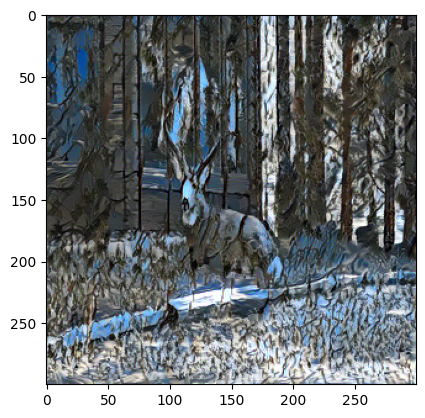

In [66]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)

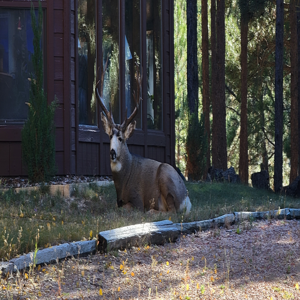

In [59]:
Image.open("images/content.jpg").resize((300, 300))

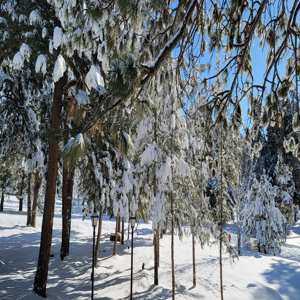

In [60]:
Image.open("images/style.jpg").resize((300, 300))